In [7]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
import seaborn as sns
import pandas as pd
from tqdm import tqdm

In [99]:
# Constants
BIG_G = 6.67e-8 # cgs
BIG_G_YR = BIG_G * 3.154e7**2
AU_TO_CM = 1.496e13
C = 2.998e10 # speed of light in cm/s
S_TO_YEAR = 3.154e7 
M_SOLAR = 0.871 * 1.989e33 # solar mass in g

In [131]:
# Secular theory for JSUN
# Modify code for a 4 planet system
# If parameters do not change, run scaled_eigenvectors once and then time evolve with orbital_elements
# Every time parameters change, need to rerun scaled_eigenvectors

# Functions for variables h, k, p, q defined in 7.18 & 7.19.  All arguments assumed to be in radians
def h(e, varphi):
    return e * np.sin(varphi)

def k(e, varphi):
    return e * np.cos(varphi) 

def p(i, omega):
    return i * np.sin(omega)

def q(i, omega):
    return i * np.cos(omega) 

def a_param(aj, ak):
    '''Helper for ab_matrix from 7.128'''
    if aj > ak:
        return ak / aj
    else:
        return aj / ak
    
def abar_param(aj, ak):
    '''Helper for ab_matrix from 7.129'''
    if aj > ak:
        return 1
    else:
        return aj / ak

def laplace_coefficients(alpha, coeff):
    '''
    Returns the 32 Laplace coefficients for a system
    
    Arguments:
    alpha = a_1 / a_2
    coeffs: b^coeff
    
    function returns the b^coeff laplace coefficient
    '''
    func = lambda phi: np.cos(coeff * phi) / ((1 - 2 * alpha * np.cos(phi) + alpha**2)**(3/2)) # M&D section 6.67
    to_return = integrate.quad(func, 0, 2 * np.pi)[0] / np.pi
    
    return to_return

def ab_matrix(m, n, a):
    '''
    Returns matrices A & B as in M & D 7.132 - 7.133 for N bodies.  Helper for scaled_eigenvectors
    THIS ASSUMES - using sun as central body
    
    m: [m1, m2, ..., mN]
    n: [n1, n2, ..., nN]
    a: [a1, a2, ..., aN]
    
    Returns [A_matrix, B_matrix]  IN UNITS OF RAD/YR
    '''
    # Necessary constants CHANGE IF USING STAR OTHER THAN SUN
    j2 = 1.3e-5 #2.2e-7 # solar zonal harmonics
    j4 = 0 #-4.45e-9
    rs = 0.852 * 0.00465 # solar radius in AU
    
    # Define the matrices
    size = len(m)
    a_mat = np.zeros((size,size))
    b_mat = np.zeros((size,size))
    
    for j in range(size):
        for k in range(size):
            if j == k: # Diagonal elements
                # define summation term in diagonal elements
                sum_term = 0
                for ii in range(size):
                    if ii == j:
                        pass
                    else:
                        b1 = laplace_coefficients(a_param(a[j], a[ii]), 1) # Laplace coefficient
                        sum_term += ((m[ii] / (M_SOLAR + m[j])) * a_param(a[j], a[ii]) * abar_param(a[j], a[ii]) * b1)

                a_mat[j][k] = n[j] * ((3 / 2) * J2_GLOB * (rs / a[j])**2 - (9 / 8) * J2_GLOB**2 * (rs / a[j])**4 - 
                                      (15 / 4) * j4 * (rs / a[j])**4 + (1 / 4) * sum_term + 
                                      ((3 * BIG_G_YR * M_SOLAR) / ((C * S_TO_YEAR)**2 * a[j] * AU_TO_CM))) # GR correction term

                b_mat[j][k] = -n[j] * ((3 / 2) * J2_GLOB * (rs / a[j])**2 - (27 / 8) * j2**2 * (rs / a[j])**4 - 
                                      (15 / 4) * j4 * (rs / a[j])**4 + (1 / 4) * sum_term)
                
            
            else: # Off Diagonal elements
                b2 = laplace_coefficients(a_param(a[j], a[k]), 2)
                a_mat[j][k] = (- (1 / 4) * (m[k] / (m_solar + m[j])) * n[j] * a_param(a[j], a[k]) * 
                               abar_param(a[j], a[k]) * b2)
                b_mat[j][k] = ((1 / 4) * (m[k] / (M_SOLAR + m[j])) * n[j] * a_param(a[j], a[k]) * 
                               abar_param(a[j], a[k]) * b1)
                
    
    return a_mat, b_mat

def scaled_eigenvectors(params):
    '''
    Computes the scaled eigenvectors as in M&D 7.50.  Time independent
    This follows M&D section 7.3 generalized to N bodies

    params - 2D array of parameters:
    p[0]: [m_1, m_2, ..., m_N]
    p[1]: [n_1, n_2, ..., n_N]
    p[2]: [i_1, i_2, ..., i_N]
    p[3]: [e_1, e_2, ..., e_N]
    p[4]: [varphi_1, varphi_2, ..., varphi_N]
    p[5]: [omega_1, omega_2, ..., omega_N]
    p[6]: [a_1, a_2, ..., a_N]

    
    Returns:
    [0] - array of scaled eigenvectors for ecc. solution - e[i] corresponds to eigenvector of ith body
    [1] - array of scaled eigenvectors for in.c solution - i[i] corresponds to eigenvector of ith body
    [2] - angle terms beta
    [3] - angle terms gamma
    [4] - eigenvalues f (for eccentricity solution)
    [5] - eigenvalues g (for inclination solution, in radians)

    '''
    # Unpack parameters
    m = params[0]
    n = params[1]
    inc = params[2]
    e = params[3]
    varphi = params[4]
    omega = params[5]
    a = params[6]
    size = len(m)
    
    # unscaled eigenvectors
    a, b = ab_matrix(m, n, a)
    
    # Eigenvalues f and g in radians per year
    g, e_coeff = np.linalg.eig(a) # solution for eccentricity solution
    f, i_coeff = np.linalg.eig(b) # solution for inclination solution
    
    # Solve according to 7.47 M&D
    # We have 4 (for each element) sets of N unknowns each
    # Set up system - first define the value of 4 orbital elements at t = 0
    elements = np.zeros((4, size))
    for i in range(size):
        elements[0][i] = h(e[i], varphi[i]) # h
        elements[1][i] = k(e[i], varphi[i]) # k
        elements[2][i] = p(inc[i], omega[i]) # p
        elements[3][i] = q(inc[i], omega[i]) # q
        
    # Solve the equations
    s_sin = np.linalg.solve(e_coeff, elements[0]) # h
    s_cos = np.linalg.solve(e_coeff, elements[1]) # k
    t_sin = np.linalg.solve(i_coeff, elements[2]) # p
    t_cos = np.linalg.solve(i_coeff, elements[3]) # q
    
    # Solve for coefficients and angles
    s_vals = np.zeros(size)
    t_vals = np.zeros(size)
    beta_vals = np.zeros(size)
    gamma_vals = np.zeros(size)
    
    for i in range(size):
        s_vals[i] = np.sqrt(s_sin[i]**2 + s_cos[i]**2)
        beta_vals[i] = np.arctan2(s_sin[i], s_cos[i])
        
        t_vals[i] = np.sqrt(t_sin[i]**2 + t_cos[i]**2)
        gamma_vals[i] = np.arctan2(t_sin[i], t_cos[i])
    
    # Scaled eigenvectors as in 7.50
    scaled_evectors = np.zeros((size, size))
    scaled_ivectors = np.zeros((size, size))
    
    for i in range(size):
        scaled_evectors[i] = s_vals[i] * e_coeff[:,i]
        scaled_ivectors[i] = t_vals[i] * i_coeff[:,i]

    return [scaled_evectors, scaled_ivectors, beta_vals, gamma_vals, g, f]


def orbital_elements(t, args):
    '''
    Computes the time-dependent orbital elements as in 7.51 for N bodies
    Split from scaled_eigenvectors so we have the option of loading in array of eigen freqs/vectors
    
    t - time
    
    args - 
    [0] evectors - 2D array of scaled eigenvectors for eccentricity solution
    [1] ivectors - 2D array of scaled eigenvectors for eccentricity solution
    [2] beta - beta angle params
    [3] gamma - gamma angle params
    [4] f - eigenvalues for ecc. solution
    [5] g - eigenvalues for inc. solution
    
    
    Returns: 
    4 x N array, where index ij represents the orbital element where j corresponds to one of N
    bodies and i to h, k, p, q
    '''
    # unpack inputs
    evectors, ivectors, beta, gamma, g, f = args
    
    # iterables != size in case there are additional resonant terms
    iterables = evectors.shape[0]
    size = evectors.shape[1]
    elements = np.zeros((4, size))
        
    for j in range(size):
        # Return orbital elements as seen in 7.137 & 7.138
        hj = 0
        kj = 0
        pj = 0
        qj = 0
        
        for i in range(iterables): # change to iterables for M&D code, revert back to size after done
            hj += evectors[i][j] * np.sin(g[i] * t + beta[i])
            kj += evectors[i][j] * np.cos(g[i] * t + beta[i])
            pj += ivectors[i][j] * np.sin(f[i] * t + gamma[i])
            qj += ivectors[i][j] * np.cos(f[i] * t + gamma[i])       
                   
        # Return orbital elements
        elements[0][j] = hj
        elements[1][j] = kj
        elements[2][j] = pj
        elements[3][j] = qj
        
    else:
        return elements # return orbital elements

In [127]:
def mean_motion(p):
    return (2 * np.pi / (p / 365)) # rad / yr

# define constants for the JSUN system
m_e = 5.97e27

m_solar = 0.871 * 1.989e33 # solar mass in g
m_1 = 2.65 * m_e # 1.898e30 # Jupiter
m_2 = 8.5 * m_e # 5.683e29 # Saturn
m_3 = 8.6 * m_e # 8.681e28 # Uranus
m_4 = 9.5 * m_e # 1.024e29 # Neptune

# Orbital elements - from M&D appendix in AU
a_1 = 0.0122 #5.202545 # Jupiter
a_2 = 0.0521 # 9.554841 # Saturn
a_3 = 0.0818 #19.19 # Uranus
a_4 = 0.1376 #30.069 # Neptune

n_1 = mean_motion(0.528) #np.radians(30.337) # Jupiter mean motion rad per year
n_2 = mean_motion(4.654) #np.radians(12.189) # Saturn
n_3 = mean_motion(9.151) # np.radians(4.27) # Uranus
n_4 = mean_motion(19.98) # np.radians(2.19) # Neptune 

e_1 = 0# 0.0484 # Jupiter eccentricity
e_2 = 0.183 #0.0542 # Saturn 
e_3 = 0.065 # 0.0471 # Uranus
e_4 = 0.075 # 0.00859 # Neptune

varphi_1 = 0 # np.radians(14.754) # Jupiter varpi
varphi_2 = np.radians(-91) # np.radians(92.432) # Saturn
varphi_3 = np.radians(90) # np.radians(170.96) # Uranus
varphi_4 = np.radians(90) # np.radians(44.971) # Neptune

i_1 = np.radians(90 - 72.80) # np.radians(1.305) # Jupiter inclination
i_2 = np.radians(90 - 88.99) # np.radians(2.484) # Saturn
i_3 = np.radians(90 - 88.52) # np.radians(0.769) # Uranus 
i_4 = np.radians(90 - 88.753) # np.radians(1.769) # Neptune

omega_1 = 0 # np.radians(100.556) # Jupiter long. of ascending node
omega_2 = 0 # np.radians(113.715) # Saturn
omega_3 = 0 # np.radians(74.230) # Uranus
omega_4 = 0 # np.radians(31.721) # Neptune

def params(m, n, i, e, varphi, omega, a):
    '''
    Method to pack our variables into a numpy 2D array for ease of use
    '''  
    return np.array([m, n, i, e, varphi, omega, a])

param_list = params([m_1, m_2, m_3, m_4], [n_1, n_2, n_3, n_4], [i_1, i_2, i_3, i_4], 
                    [e_1, e_2, e_3, e_4], [varphi_1, varphi_2, varphi_3, varphi_4], 
                    [omega_1, omega_2, omega_3, omega_4], [a_1, a_2, a_3, a_4])

In [136]:
# Evolve the JSUN system
j2s = np.linspace(6e-6, 2e-5, 100)
record = np.zeros((len(j2s), 2))
for j, j2 in tqdm(enumerate(j2s)):
    J2_GLOB = j2
    output = scaled_eigenvectors(param_list) 

    Nout = 10000
    times = np.linspace(0, 1e5, Nout)

    usp = np.zeros((Nout, 4))
    #sat = np.zeros((Nout, 4))
    #ur = np.zeros((Nout, 4))
    #nep = np.zeros((Nout, 4))

    for i, time in enumerate(times):
        elements = orbital_elements(time, output)
        usp[i] = elements[:,0]
        #sat[i] = elements[:,1]
        #ur[i] = elements[:,2]
        #nep[i] = elements[:,3]
        inc = np.degrees(np.sqrt(usp[:,2]**2 + usp[:,3]**2))
    amp = np.max(inc) - np.min(inc)
    record[j] = J2_GLOB, amp

51it [01:32,  1.85s/it]/Users/tigerlu/opt/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:166: ComplexWarning: Casting complex values to real discards the imaginary part
51it [01:32,  1.82s/it]


TypeError: ufunc 'arctan2' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

9.111627561154887e-06

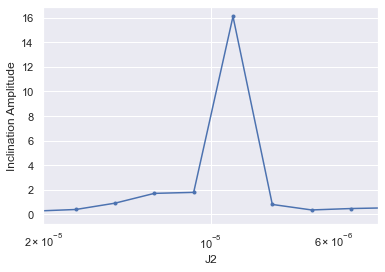

In [134]:
plt.plot(record[:,0], record[:,1], marker = '.')
plt.xscale('log')
plt.xlim(2e-5, 5e-6)
plt.xlabel('J2')
plt.ylabel('Inclination Amplitude')
record[:,0][56]

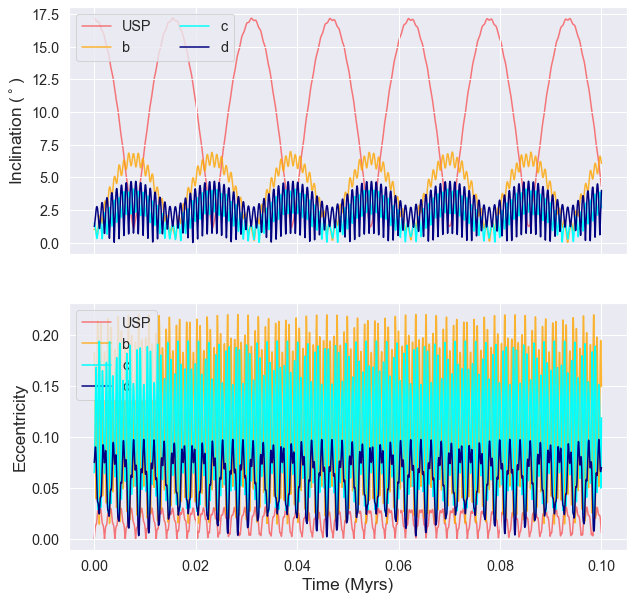

In [125]:
sns.set()
fig, ax = plt.subplots(2, 1, figsize=(10,10), sharex = True)
mask = 1
ax[0].plot(times[::mask] / 1e6, np.degrees(np.sqrt(usp[:,2]**2 + usp[:,3]**2))[::mask], color = 'red', zorder = 0, alpha = 0.5, label = 'USP')
ax[0].plot(times[::mask] / 1e6, np.degrees(np.sqrt(sat[:,2]**2 + sat[:,3]**2))[::mask], color = 'orange', zorder = 5, alpha = 0.8, label = 'b')
ax[0].plot(times[::mask] / 1e6, np.degrees(np.sqrt(ur[:,2]**2 + ur[:,3]**2))[::mask], color = 'cyan', zorder = 10, label = 'c')
ax[0].plot(times[::mask] / 1e6, np.degrees(np.sqrt(nep[:,2]**2 + nep[:,3]**2))[::mask], color = 'navy', zorder = 11, label = 'd')
# plt.xlim(0, 1e6)
ax[0].legend(loc=2, ncol = 2, fontsize='large')
ax[0].set_ylabel(r'Inclination ($^\circ$)', size = 'x-large')
# ax[0].set_ylim(0, 3.5)
ax[0].tick_params(axis = 'y', labelsize='large')

ax[1].plot(times[::mask] / 1e6, np.sqrt(usp[:,0]**2 + usp[:,1]**2)[::mask], color = 'red', zorder = 0, alpha = 0.5, label = 'USP')
ax[1].plot(times[::mask] / 1e6, np.sqrt(sat[:,0]**2 + sat[:,1]**2)[::mask], color = 'orange', zorder = 5, alpha = 0.8, label = 'b')
ax[1].plot(times[::mask] / 1e6, np.sqrt(ur[:,0]**2 + ur[:,1]**2)[::mask], color = 'cyan', zorder = 10, label = 'c')
ax[1].plot(times[::mask] / 1e6, np.sqrt(nep[:,0]**2 + nep[:,1]**2)[::mask], color = 'navy', zorder = 11, label = 'd')
ax[1].set_xlabel('Time (Myrs)', size = 'x-large')
ax[1].legend(loc=2, fontsize='large')
ax[1].set_ylabel('Eccentricity', size = 'x-large')
ax[1].tick_params(axis = 'y', labelsize='large')
ax[1].tick_params(axis = 'x', labelsize='large')


In [ ]:
## sns.set()
fig, ax = plt.subplots(2, 1, figsize=(10,10), sharex = True)
#ax[0].plot(times / 1e6, np.degrees(np.arctan2(jup[:,2]**2, jup[:,3]**2)), color = 'red', zorder = 0, alpha = 0.5, label = 'Jupiter')
#ax[0].plot(times / 1e6, np.degrees(np.arctan2(sat[:,2]**2, sat[:,3]**2)), color = 'orange', zorder = 5, alpha = 0.8, label = 'Saturn')
ax[0].plot(times / 1e6, np.degrees(np.arctan2(ur[:,2]**2, ur[:,3]**2)), color = 'cyan', zorder = 10, label = 'Uranus')
ax[0].plot(times / 1e6, np.degrees(np.arctan2(nep[:,2]**2, nep[:,3]**2)), color = 'navy', zorder = 11, label = 'Neptune')
# plt.xlim(0, 1e6)
ax[0].legend(loc=2, ncol = 2, fontsize='large')
ax[0].set_ylabel(r'$\Omega$ ($^\circ$)', size = 'x-large')
# ax[0].set_ylim(0, 3.5)
ax[0].tick_params(axis = 'y', labelsize='large')

#ax[1].plot(times / 1e6, np.degrees(np.arctan2(jup[:,0]**2, jup[:,1]**2)), color = 'red', zorder = 0, alpha = 0.5, label = 'Jupiter')
#ax[1].plot(times / 1e6, np.degrees(np.arctan2(sat[:,0]**2, sat[:,1]**2)), color = 'orange', zorder = 5, alpha = 0.8, label = 'Saturn')
ax[1].plot(times / 1e6, np.degrees(np.arctan2(ur[:,0]**2, ur[:,1]**2)), color = 'cyan', zorder = 10, label = 'Uranus')
ax[1].plot(times / 1e6, np.degrees(np.arctan2(nep[:,0]**2, nep[:,1]**2)), color = 'navy', zorder = 11, label = 'Neptune')
ax[1].set_xlabel('Time (Myrs)', size = 'x-large')
ax[1].legend(loc=2, fontsize='large')
ax[1].set_ylabel(r'$\varpi$ ($^\circ$)', size = 'x-large')
ax[1].tick_params(axis = 'y', labelsize='large')
ax[1].tick_params(axis = 'x', labelsize='large')